In [33]:
import unittest

if __name__ == "__main__":
    loader = unittest.TestLoader()
    start_dir = "../tests"
    suite = loader.discover(start_dir)
    runner = unittest.TextTestRunner()
    runner.run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 0.365s

OK


In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from typing import Union
from getdist import MCSamples, plots
basedir = os.path.dirname(os.path.abspath(''))
sourcedir = os.path.join(basedir, 'source')
import sys
sys.path.insert(0, sourcedir)
from source.mcmc import MCMC

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

chains = []  # will contain the main two chains made in this file
# one with systematics, one without systematics

default_chain_length = 10000

#################################################
# Function defs
#################################################

names = ["$\Omega_m$", "$\Omega_{\Lambda}$", "$H_0$", "$M$" ]

def make_trace_plot(_chains, labels=names, ylims=None):
    if ylims is None:
        ylims = [[0, 1], [0, 1], [50, 100], [-25, -15]]
    fig, ax = plt.subplots(4,1, figsize=(8, 10))
    if type(_chains) != list:
        _chains = [_chains]
    for chain in _chains:
        for i in np.arange(4):
            ax[i].plot(chain[:,i])
            ax[i].set_ylim(ylims[i])
            ax[i].set_ylabel(labels[i], fontsize=14)
    return fig,ax



#################################################
# Directory setup
#################################################

datadir = os.path.join(basedir, 'data')
binned_data_file = os.path.join(datadir, 'lcparam_DS17f.txt')
binned_sys_file = os.path.join(datadir, 'sys_DS17f.txt')

# With Systematics

## Initial chain to estimate generating function covariance

Below we run a shorter chain to get a rough estimate of the covariance between parameters. This will then be used to run a longer chain for actual parameter estimates.

In [35]:
def make_chain(systematics_file, cov, M_gaussian_prior, chain_length):
    start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), np.random.uniform(-25, -15)]
    if M_gaussian_prior:
        start[3] = -19.15

    markov_chain = MCMC(initial_state=start,
                        data_file=binned_data_file,
                        systematics_file=systematics_file,
                        g_cov=cov,
                        M_gaussian_prior=M_gaussian_prior)

    markov_chain.make_chain(chain_length)

    # test values
    h0_average = np.average(markov_chain.H0[1000:])
    Omega_m_average = np.average(markov_chain.Omega_m[1000:])
    Omega_L_average = np.average(markov_chain.Omega_L[1000:])
    M_average = np.average(markov_chain.M[1000:])
    assert 50 < h0_average < 99, f"The average value for H0 ({h0_average}) has fallen out of the expected range"
    assert 0.01 < Omega_m_average < 0.5, f"The average value for Omega_m ({Omega_m_average}) has fallen out of the expected range"
    assert 0.5 < Omega_L_average < 0.99, f"The average value for Omega_L ({Omega_L_average}) has fallen out of the expected range"
    assert -22 < M_average < -18, f"The average value for M ({M_average}) has fallen out of the expected range"
    print(f"{h0_average=}, {Omega_m_average=}, {Omega_L_average=}, {M_average=}")

    return markov_chain

In [36]:
systematics_markov_chain = make_chain(binned_sys_file,
                                      cov=np.diag([.01, .01, .1, .01]),
                                      M_gaussian_prior=False,
                                      chain_length=default_chain_length)

h0_average=59.18909245670173, Omega_m_average=0.3450479000190227, Omega_L_average=0.7798770473053356, M_average=-19.72036752349426


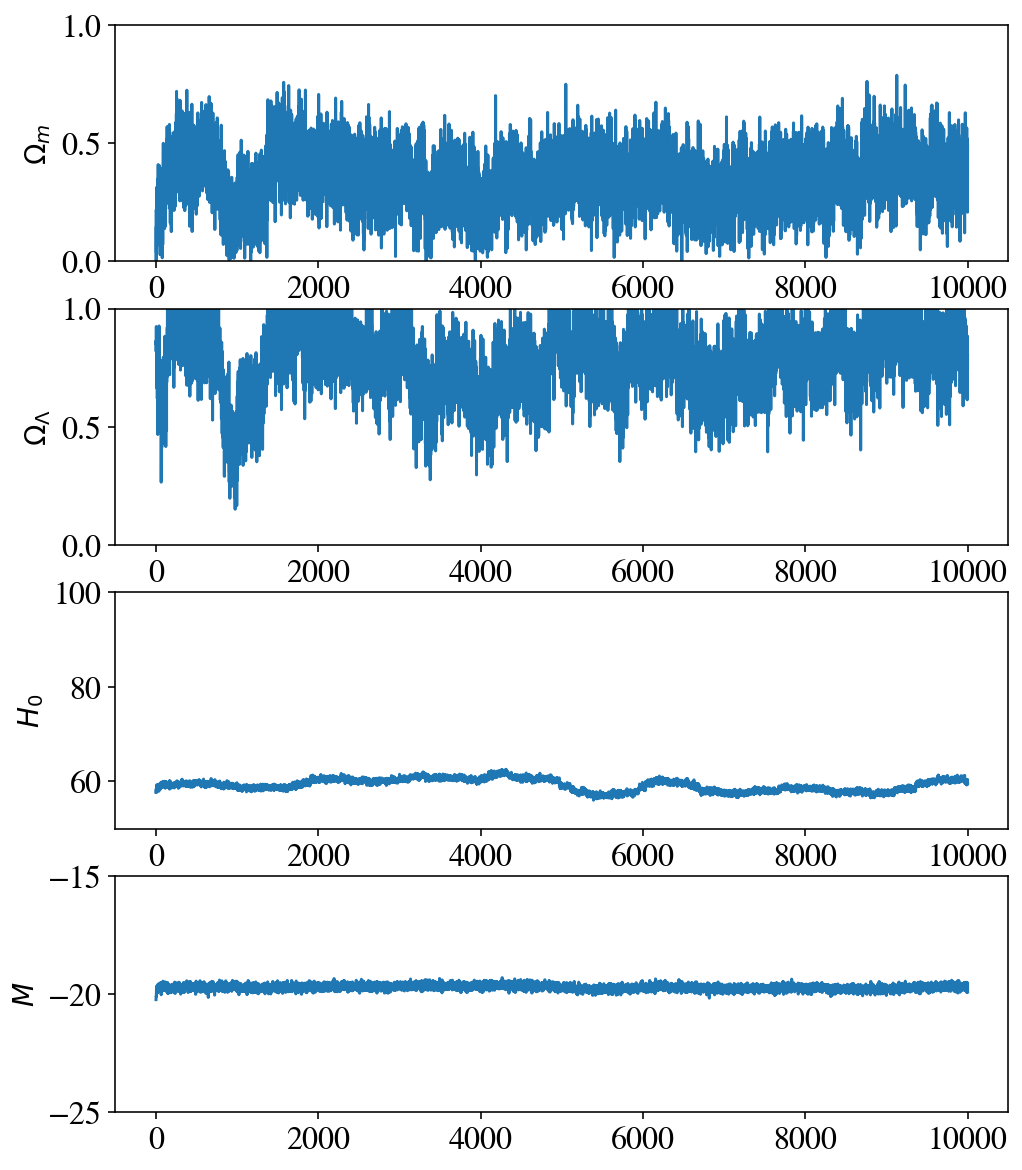

In [37]:
def plot_chain(markov_chain: Union[MCMC, np.ndarray]) -> None:
    """
    Makes a trace plot using make_trace_plot() function above.
    :param markov_chain: Chain object to make a
    """
    if type(markov_chain) == MCMC:
        markov_chain = markov_chain.chain

    _, _ = make_trace_plot(markov_chain)
    plt.show()

plot_chain(systematics_markov_chain)

Now we use the above chains to estimate the parameter covariance, which will be used to refine the generating function on the next run.

In [38]:
def estimate_covariance(markov_chain, burn_in, alpha):
    cov = np.cov(markov_chain.chain[burn_in:, :].T)
    cov *= alpha
    print(cov)
    return cov

systematics_better_cov = estimate_covariance(systematics_markov_chain,
                                             burn_in=500,
                                             alpha=0.1)

[[ 1.42889188e-03  6.00869146e-04 -6.57847451e-04 -6.35153203e-05]
 [ 6.00869146e-04  2.05705489e-03 -1.44857816e-03 -1.33572095e-04]
 [-6.57847451e-04 -1.44857816e-03  1.64265422e-01  5.84247395e-03]
 [-6.35153203e-05 -1.33572095e-04  5.84247395e-03  1.22162988e-03]]


In [39]:
# def make_chain_with_better_covariance(cov):
#     start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), np.random.uniform(-25, -15)]
#
#     markov_chain = MCMC(initial_state=start,
#                         data_file=binned_data_file,
#                         systematics_file=binned_sys_file,
#                         g_cov=cov)
#
#     markov_chain.make_chain(50000)
#     return markov_chain

h0_average=77.05969175868871, Omega_m_average=0.3244537611018914, Omega_L_average=0.7463404359609843, M_average=-19.181062685291934


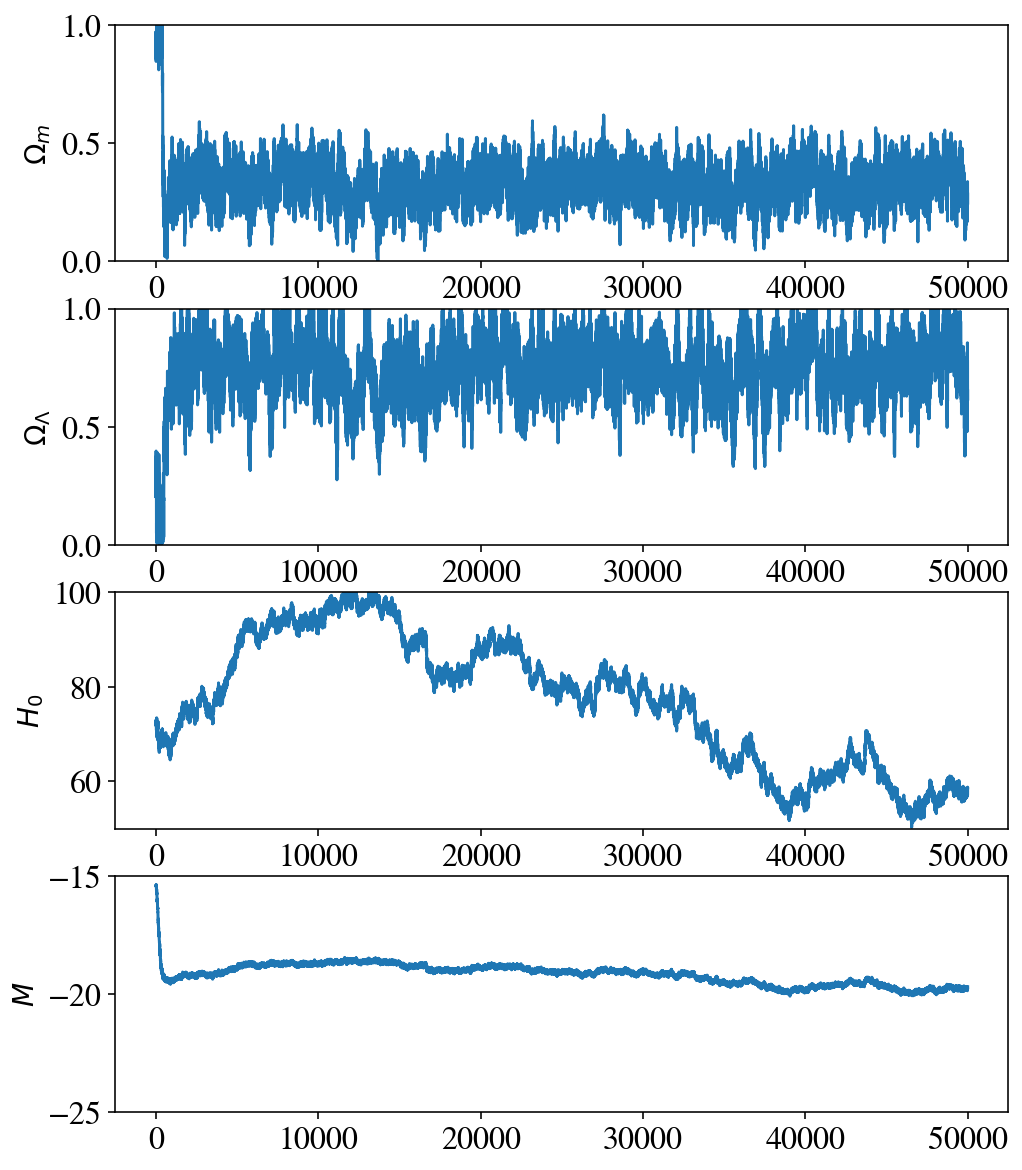

In [40]:
# def plot_systematics_better_cov(markov_chain):
#     chains = []
#     chains.append(markov_chain.chain)
#     fig,ax= make_trace_plot(chains)
#     plt.show()

with_systematics_better_cov_chain = make_chain(binned_sys_file,
                                               systematics_better_cov,
                                               M_gaussian_prior=False,
                                               chain_length=default_chain_length*5)

chains.append(with_systematics_better_cov_chain)
plot_chain(with_systematics_better_cov_chain)

# Without Systematics

h0_average=52.01563941513444, Omega_m_average=0.3588663220530917, Omega_L_average=0.8567735658305434, M_average=-20.012119330337498
[[ 1.16834445e-03  2.24962915e-04 -3.60951295e-04 -1.28587743e-05]
 [ 2.24962915e-04  1.41677458e-03 -6.69562317e-04 -5.51789660e-05]
 [-3.60951295e-04 -6.69562317e-04  7.87349386e-02  3.02155878e-03]
 [-1.28587743e-05 -5.51789660e-05  3.02155878e-03  1.13399886e-03]]
h0_average=60.13308970477026, Omega_m_average=0.35934769648457726, Omega_L_average=0.8472625758717391, M_average=-19.710813223098054


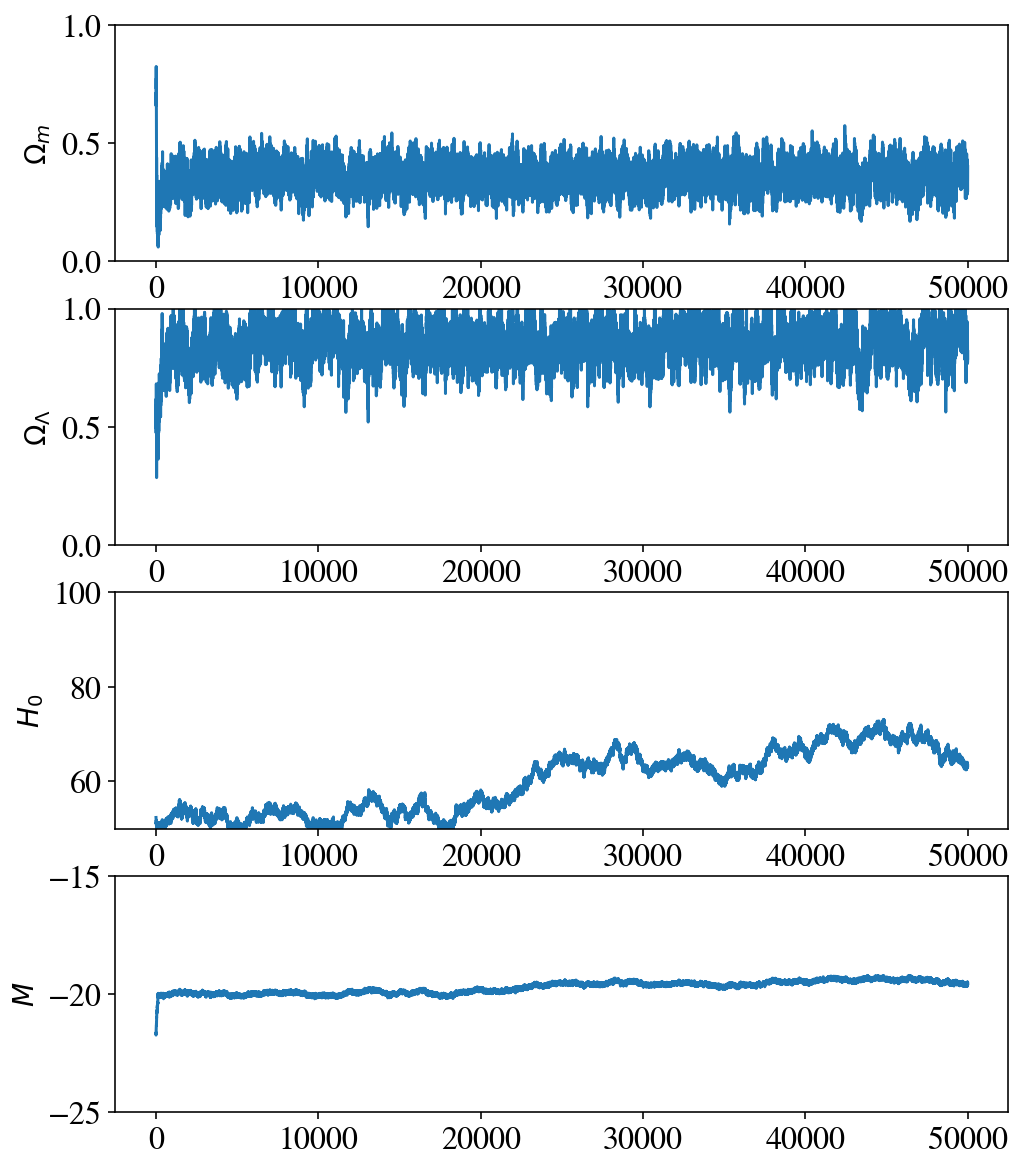

In [41]:
# start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), np.random.uniform(-25, -15)]
# g_cov = np.diag([.01, .01, .1, .01])
#
# markov_chain = MCMC(initial_state=start,
#                     data_file=binned_data_file,
#                     systematics_file=None,
#                     g_cov=g_cov)
#
# markov_chain.make_chain(10000)

no_systematics_chain = make_chain(systematics_file=None,
                                  cov=np.diag([.01, .01, .1, .01]),
                                  M_gaussian_prior=False,
                                  chain_length=default_chain_length)

no_systematics_better_cov = estimate_covariance(no_systematics_chain,
                                                burn_in=500,
                                                alpha=0.1)
# burn_in = 500
# cov = np.cov(markov_chain.chain[burn_in:, :].T)
# alpha= .1
# cov*=alpha
# print(cov)

# start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), np.random.uniform(-25, -15)]
#
# markov_chain = MCMC(initial_state=start,
#                     data_file=binned_data_file,
#                     systematics_file=None,
#                     g_cov=cov)
#
# markov_chain.make_chain(50000)

no_systematics_better_cov_chain = make_chain(systematics_file=None,
                                             cov=no_systematics_better_cov,
                                             M_gaussian_prior=False,
                                             chain_length=default_chain_length*5)

chains.append(no_systematics_better_cov_chain)
plot_chain(no_systematics_better_cov_chain)

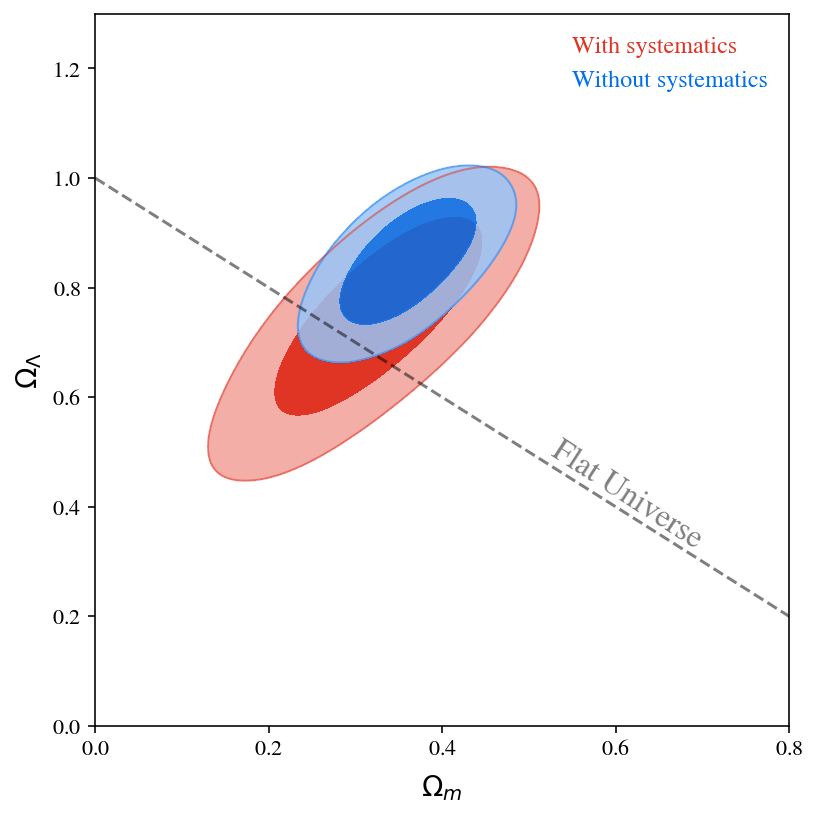

In [42]:
def make_omega_contour_plot():
    burn_in = 1000
    p_names = ['Om', 'Ol', "H0", "M"]
    p_labels = ['\Omega_m', '\Omega_\Lambda', "H_0", "M"]

    sys_samples = MCSamples(samples=with_systematics_better_cov_chain.chain,
                            names = p_names,
                            labels = p_labels,
                            ignore_rows=burn_in)

    no_sys_samples = MCSamples(samples=no_systematics_better_cov_chain.chain,
                               names = p_names,
                               labels = p_labels,
                               ignore_rows=burn_in)

    sys_samples.updateSettings({'contours': [0.68, 0.95]})
    no_sys_samples.updateSettings({'contours': [0.68, 0.95]})
    om_grid = np.linspace(0,1,100)
    g = plots.get_single_plotter(width_inch=6, ratio=1. / 1)
    g.get_axes().plot(om_grid, -om_grid+1, linestyle="dashed", color="k", alpha=0.5)
    g.get_axes().text(0.65, 0.25, 'Flat Universe', rotation=-33, alpha=0.5, transform=g.get_axes().transAxes)
    g.plot_2d([sys_samples, no_sys_samples], p_names[0], p_names[1], filled=True, lims=[0, 0.8, 0, 1.3])

    g.add_legend(['With systematics', 'Without systematics'], colored_text=True)
    return g

omega_contour_plot = make_omega_contour_plot()

In [43]:
def save_omega_contour_plot(graph):
    resultsdir = os.path.join(basedir, 'results')
    out_name = os.path.join(resultsdir, "omega_contour_plot.pdf")

    save_plot = False
    if save_plot:
        graph.export(fname=out_name)

save_omega_contour_plot(omega_contour_plot)

# Constraints on $H_0$


In [44]:
def make_h0_constraints_chain():
    chain = make_chain(systematics_file=binned_sys_file,
                       cov=np.diag([.01, .01, .1, .01]),
                       M_gaussian_prior=True,
                       chain_length=default_chain_length)

    better_cov = estimate_covariance(chain,
                                     burn_in=500,
                                     alpha=0.5)

    chain = make_chain(systematics_file=binned_sys_file,
                       cov=better_cov,
                       M_gaussian_prior=True,
                       chain_length=default_chain_length*5)

    return chain

    #start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), np.random.uniform(-25, -15)]
    # start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), -19.15]
    #
    # g_cov = np.diag([.01, .01, .1, .01])
    #
    # markov_chain = MCMC(initial_state=start,
    #                     data_file=binned_data_file,
    #                     systematics_file=binned_sys_file,
    #                     g_cov=g_cov,
    #                     M_gaussian_prior = True)
    #
    # markov_chain.make_chain(10000)

    # burn_in = 500
    # cov = np.cov(markov_chain.chain[burn_in:, :].T)
    # alpha= 0.5
    # cov*=alpha
    # print(cov)

    #start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), -19.15]
    # start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), -19.15]
    #
    #
    # markov_chain = MCMC(initial_state=start,
    #                     data_file=binned_data_file,
    #                     systematics_file=binned_sys_file,
    #                     g_cov=cov,
    #                     M_gaussian_prior = True)
    #
    # markov_chain.make_chain(50000)

h0_chain = make_h0_constraints_chain()
plot_chain(h0_chain)

AssertionError: The average value for Omega_m (0.9454874569955489) has fallen out of the expected range

In [ ]:
def plot_h0_constraint(markov_chain):
    burn_in = 1000
    p_names = ['Om', 'Ol', "H0", "M"]
    p_labels = ['\Omega_m', '\Omega_\Lambda', "H_0", "M"]
    H0_samples = MCSamples(samples=markov_chain.chain,
                           names = p_names,
                           labels = p_labels,
                           ignore_rows=burn_in)

    g = plots.get_single_plotter(width_inch=6, ratio=1. / 1.6)
    g.plot_1d(H0_samples, p_names[2])

plot_h0_constraint(h0_chain)